In [1]:
from src.infer_models import infer
from src.preprocess_modified import preprocess
from src.archs_models import stdlogistic
from src.opts_models import batchgd
import os
import sys
import pathlib
from pathlib import Path

import numpy as np
from numpy.core.shape_base import block
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"]})  # Avant Garde, Helvetica, Computer Modern Sans Serif
# for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"], # Times, Bookman, Pa;atino
# })
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "monospace",
#     "font.monospace": ["Consolas"],
# })

np.set_printoptions(precision=4)
np.set_printoptions(formatter={'float': "{:0.4f}".format})


# Ensure path is referenced to this script's root
# thisdir = os.path.dirname(__file__)
thisdir = Path.cwd()
# os.chdir(thisdir)
os.chdir(sys.path[0])
print(os.getcwd())

figs_dir = os.path.join(thisdir, 'figs/')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

# os.chdir(r'./ai534ias/ia1/')

# Generate the path to the file relative to your python script:
# script_location = Path(__file__).absolute().parent
# print(script_location)
# file_location = script_location / 'file.yaml'
# file = file_location.open()

# Data Preprocessing

# do major feature engineering - 0 | 1
doengr = 0
donormalize = 1

# Train
rawdata = 'csvs/IA2-train.csv'
traindata, train_id = preprocess(rawdata, donormalize=donormalize)

# View final data entering the model.
print(traindata)
# print(traindata['X'].shape)

# Dev
rawdata = 'csvs/IA2-dev.csv'
devdata, dev_id = preprocess(rawdata, donormalize=donormalize)
print(devdata)


c:\Users\aorukotan\OneDrive - Smithfield Foods, Inc\Desktop\Machine Learning\Workspace\Logistic Regression\1A2
data size (rows,columns) (6000, 198)
[[0.0000 0.8362 -1.1719 ... -0.2046 -0.1148 1.0094]
 [0.0000 -1.1959 0.2426 ... -0.2046 -0.1148 1.0094]
 [0.0000 -1.1959 -0.6061 ... -0.2046 -0.1148 1.0094]
 ...
 [0.0000 -1.1959 -0.2525 ... 4.8884 -0.1148 1.0094]
 [0.0000 -1.1959 -0.2525 ... -0.2046 -0.1148 1.0094]
 [0.0000 0.8362 1.8693 ... -0.2046 -0.1148 -0.9907]]
{'X': array([[ 1,  1, 24, ...,  0,  0,  1],
       [ 1,  0, 44, ...,  0,  0,  1],
       [ 1,  0, 32, ...,  0,  0,  1],
       ...,
       [ 1,  0, 37, ...,  1,  0,  1],
       [ 1,  0, 37, ...,  0,  0,  1],
       [ 1,  1, 67, ...,  0,  0,  0]], dtype=int64), 'Y': array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int64), 'rows': 6000, 'cols': 198, 'scalers': array([[0.0000, 0.8362, -1.1719, ..., -0.2046, -0.1148, 1.0094],
       [0.0000, -1.1959, 0.2426, ..., -0.2046, -0.1148, 1.0094],

In [2]:

# DEV: Model Training and Selection

# - max. number of iterations (fixed) - epochs
epochs = int(5e3)

# - learning-rate (step-size) selection set
# lrs =  [5e-3, 1e-2, 2e-2, 0.1, 0.5]
# learning rate
stepsize = 1e-1

# - regularization scale size selection set
lregs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
# lregs = [1e-3, 1e-2, 1e-1, 1]
# regsize = 0.01 # 1e-1 to 1e-2 to 1e-3

# - random weight initialization
W = np.random.uniform(0, 0.02, (traindata['cols'], 1))
W[0] = np.zeros(shape=(1, 1))
#print(W[0])


# Turns out lists and dicts are passed by ref. in python.
# They behave as global variables, modified in function they are passed to.

# model's number of largest weighted features
bigks = 5

# list to hold all models
model_sels = []

# regularization rate
# regtype = 1
regtype = 2
# regtype = 3


In [3]:

# for stepsize in lrs:
for regsize in lregs:

    print(f'\n*******L{regtype}: Model Selection************************')
    print('(start): Regularization-scale: ', regsize)
    # print(W.T) # to debug mutability

    # - modeldict: data structure that holds details of the trained model
    modeldict = {'W': W.copy(), 'stepsize': stepsize,
                 'reg_type': regtype, 'reg_size': regsize, 'epochs': epochs,
                 'cols': traindata['cols'],
                 'normalize': traindata['scalers'],
                 'mse_train': None, 'mse_dev': None,
                 'facc_train': None, 'facc_dev': None,
                 'sparsity': None, 'bigk': bigks, 'WBigK': None, 'WBigK_feats': None
                 }

    # - train: iterative line search (full batch)
    batchgd(modeldict, stdlogistic, traindata, devdata)
    model_sels.append(modeldict)


    if np.isfinite(modeldict['mse_train'][-1]):
        print(f"MSE (Train): {modeldict['mse_train'][-1]:2.4f} | "
              f"(Validation): {modeldict['mse_dev'][-1]:2.4f}")
        print(f"Class Accuracy (Train): {modeldict['facc_train'][-1]:2.4f} | "
              f"(Validation): {modeldict['facc_dev'][-1]:2.4f}")

        # print(W.T)
        print(f"Model Sparsity: {modeldict['sparsity']}")
        print('Final Learned Weights')
        # print((modeldict['W']).T)
        # Print top 5 weighted features
        print("Features (Top-5) with largest weight magnitude")
        print(modeldict['WBigK_feats'].tolist())
        wbigk_str = np.array2string(modeldict['WBigK'].flatten(),
                                    formatter={'float_kind': '{0:2.4f}'.format})
        print(wbigk_str)
        print('(end): ----\n')






*******L2: Model Selection************************
(start): Regularization-scale:  0.001
k:     0, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066


c:\Users\aorukotan\OneDrive - Smithfield Foods, Inc\Desktop\Machine Learning\Workspace\Logistic Regression\1A2\src\archs_models.py:30: RuntimeWarning: overflow encountered in exp
  return  1/(1 + np.exp(-v))


k:   500, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  1000, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  1500, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  2000, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  2500, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  3000, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  3500, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  4000, mse(train): 0.5047, mse(dev): 0.4934 | facc(train): 0.4953, facc(dev): 0.5066
k:  4500, mse(train): 0.4953, mse(dev): 0.5066 | facc(train): 0.5047, facc(dev): 0.4934
MSE (Train): 0.4953 | (Validation): 0.5066
Class Accuracy (Train): 0.5047 | (Validation): 0.4934
Model Sparsity: 90
Final Learned Weights
Features (Top-5) with largest weight magnitude
['Vintage', 'Annual_Pre

c:\Users\aorukotan\OneDrive - Smithfield Foods, Inc\Desktop\Machine Learning\Workspace\Logistic Regression\1A2\src\opts_models.py:118: RuntimeWarning: overflow encountered in multiply
  W[0] +=(lambda_lr*lambda_reg)*W[0]
c:\Users\aorukotan\OneDrive - Smithfield Foods, Inc\Desktop\Machine Learning\Workspace\Logistic Regression\1A2\src\opts_models.py:117: RuntimeWarning: invalid value encountered in subtract
  W -=(lambda_lr*lambda_reg)*W


Terminate: mse -> inf

*******L2: Model Selection************************
(start): Regularization-scale:  1000.0
k:     0, mse(train): 0.5047, mse(dev): 0.5066 | facc(train): 0.4953, facc(dev): 0.4934
Terminate: mse -> inf


c:\Users\aorukotan\OneDrive - Smithfield Foods, Inc\Desktop\Machine Learning\Workspace\Logistic Regression\1A2\src\opts_models.py:117: RuntimeWarning: overflow encountered in multiply
  W -=(lambda_lr*lambda_reg)*W


Regularization Plot...	


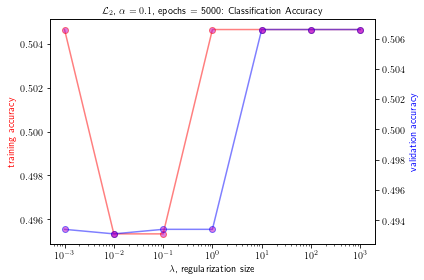

Done.

Sparsity Plot...	


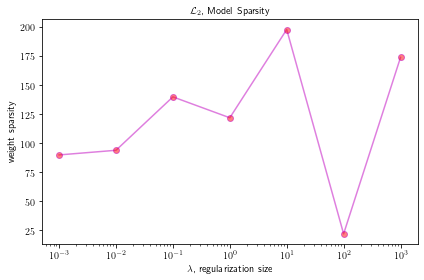

Done.



In [4]:

# Other Plots
faccs_train = []
faccs_dev = []
regular_szs = []
sparse_wts = []
for mdl in model_sels:
    faccs_train.append(mdl['facc_train'][-1])
    faccs_dev.append(mdl['facc_dev'][-1])
    sparse_wts.append(mdl['sparsity'])
    regular_szs.append(mdl['reg_size'])

print('Regularization Plot...\t')
fig, ax3 = plt.subplots(figsize=(6, 4), tight_layout=True)
ax3.semilogx(regular_szs, faccs_train,
             color='r', marker='o', markerfacecolor='m', zorder=2.5, alpha=0.5)
ax3.set_ylabel(f'training accuracy', color='r')
ax4 = ax3.twinx()
ax4.semilogx(regular_szs, faccs_dev,
             color='b', marker='o', markerfacecolor='m', zorder=2.5, alpha=0.5)
ax4.set_ylabel(f'validation accuracy', color='b')
ax3.set_xlabel(f'$\\lambda$, regularization size')
ax3.set_title(f"$\\mathcal{{L}}_{{{regtype:1d}}}$, $\\alpha = {stepsize:2.1g}$, epochs = {epochs}: Classification Accuracy",
              color='k', weight='bold', size=10)
# plt.ion
plt.savefig(figs_dir + f"L{regtype}_trainvalcmp_plt.pdf", bbox_inches='tight')
plt.show(block=False)
print('Done.\n')


print('Sparsity Plot...\t')
fig, ax5 = plt.subplots(figsize=(6, 4), tight_layout=True)
ax5.semilogx(regular_szs, sparse_wts,
             color='m', marker='o', markerfacecolor='r', zorder=2.5, alpha=0.5)
ax5.set_xlabel(f'$\\lambda$, regularization size')
ax5.set_ylabel(f'weight sparsity')
ax5.set_title(f"$\\mathcal{{L}}_{{{regtype:1d}}}$, Model Sparsity",
              color='k', weight='bold', size=10)
# plt.ion
plt.savefig(figs_dir + f"L{regtype}_sparsityplt.pdf", bbox_inches='tight')
plt.show(block=False)
print('Done.\n')
